In [1]:
import os
import json

import pandas as pd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
load_dotenv()

from openai import OpenAI
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI()

import notebook_bootstrap 

import config
from utilities import text_to_query_prompt, text_to_query_llm, rag_judge_prompt_builder
from run_query import rag

/home/rajinder-mavi/code/SME/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FILES = {
    'md':config.MD_JSONL,
    'txt':config.TXT_JSONL
}
KEYWORDS = ("introduction", "detail", "prelim", "result")
NUMBER_RANDOM_ELEMENTS = 20

In [3]:
# Get ALL md & txt chunks that are in sections named after the KEYWORDS
# Get a random subset of those chunks
# Build prompts to get queries related to text chunks from llm

md_evaluations = text_to_query_prompt(FILES["md"],KEYWORDS,NUMBER_RANDOM_ELEMENTS)
txt_evaluations = text_to_query_prompt(FILES["txt"],KEYWORDS,NUMBER_RANDOM_ELEMENTS)

In [4]:
# Evaluate prompts to get queries

text_to_query_llm(md_evaluations,client)
text_to_query_llm(txt_evaluations,client)

# DROP EMPTY QUERIES
md_evaluations = [entry for entry in md_evaluations if len(entry['query']) > 0]
txt_evaluations = [entry for entry in txt_evaluations if len(entry['query']) > 0]


In [5]:
print('___ EXAMPLE ___')
print(f'>>> TEXT: {md_evaluations[0]['text']}')
print(f'>>> QUERY: {md_evaluations[0]['query']}')

___ EXAMPLE ___
>>> TEXT: Before ending this introduction we give a short account of the existing results (to our knowledge) on the Cantor spectrum of the Almost Mathieu operator for $|b|\ne 0,2$. The Cantor spectrum for the Almost Mathieu operator was first conjectured by Azbel and Kac, in 1981, conjectured that all the spectral gaps are open. The problem of the Cantor structure of the spectrum was called the “Ten Martini Problem” by Simon (and remained as Problem 4 in ). Sinai , proved that for Diophantine $\omega$’s and sufficiently large (or small $|b|$), depending on $\omega$, the spectrum $\sigma_b$ is a Cantor set. Choi, Elliott & Yui proved that the spectrum $\sigma_b$ is a Cantor set for all $b \ne 0$ when $\omega$ is a Liouville number obeying the condition $$\left| \omega - \frac{p}{q} \right| < D^{-q},$$ for a certain constant $D>1$ and infinitely many rationals $p/q$. In particular, this means that for a $G_\delta$-dense subset of pairs $(b,\omega)$ the spectrum is a Canto

In [6]:
print('___ EXAMPLE ___')
print(f'>>> TEXT: {txt_evaluations[0]['text']}')
print(f'>>> QUERY: {txt_evaluations[0]['query']}')

___ EXAMPLE ___
>>> TEXT: [Kotani 1997]
For almost every ,

The inequality "" in acpartids follows from idsaverage (i.e., the
density of states measure is the average of the measures ) and the fact that
the average of absolutely continuous measures is absolutely continuous.

To prove the opposite inequality, we first note that for almost every , greenids, ggprime, and Cauchy-Riemann imply

Because of ggprime, oneimbound and Fatou's lemma, proppartb
implies that for almost every pair ,

and

Thus, for almost every ,

Let  be the Poisson kernel for the upper half-plane, that is,

Write

and

Then, by hm and Jensen's inequality, we obtain for almost every ,
*

Thus, for almost every ,

and hence

since  and  as .

Using lekac, Proposition , the inequality  for
, and then hm2, we find that
*
concluding the proof of "" in acpartids.

The spectrum is almost surely purely absolutely continuous if and only if the integrated
density of states is absolutely continuous and the Lyapunov exponent v

In [7]:
evaluations = []

for entry in md_evaluations:
    query = entry['query']
    text = entry['text']
    rag_response = rag(query)

    system, user = rag_judge_prompt_builder(text,query,rag_response)

    judge_response = client.responses.create(
            model="gpt-4o",
            input=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
            text={"format": {"type": "json_object"}},
        )
    judge_response = json.loads(judge_response.output_text)
    judge_response.update({'etl':'md'})
    evaluations.append(judge_response)


for entry in txt_evaluations:
    query = entry['query']
    text = entry['text']
    rag_response = rag(query)

    system, user = rag_judge_prompt_builder(text,query,rag_response)

    judge_response = client.responses.create(
            model="gpt-4o",
            input=[
                {"role": "system", "content": system},
                {"role": "user", "content": user},
            ],
            text={"format": {"type": "json_object"}},
        )
    judge_response = json.loads(judge_response.output_text)
    judge_response.update({'etl':'txt'})
    evaluations.append(judge_response)


judge_df = pd.DataFrame.from_records(evaluations)


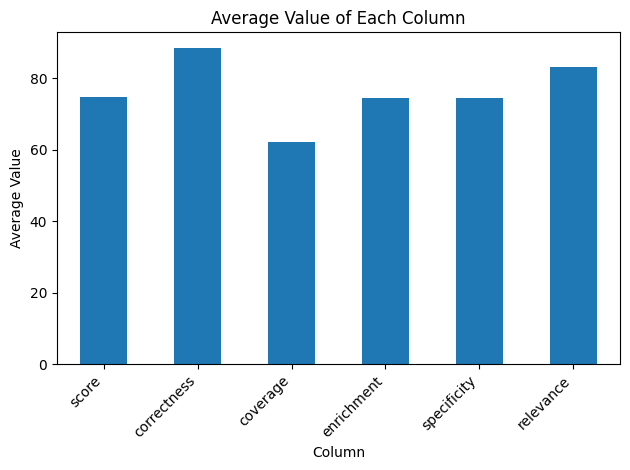

In [8]:
numeric_cols = ['score','correctness','coverage','enrichment','specificity','relevance']
judge_averages = (judge_df[numeric_cols]*[1,100,100,100,100,100]).mean()
judge_averages.plot(kind='bar')
plt.title('Average Value of Each Column')
plt.xlabel('Column')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability if many columns
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [10]:
judge_df

,score,correctness,coverage,enrichment,specificity,relevance,band,original_key_points,improvements_added_by_rag,issues_found,contradictions,verdict,etl
0,80,1.0,0.6,1.0,0.8,0.9,good,[The Cantor spectrum for the Almost Mathieu op...,[Explanation of Anderson localization and its ...,[The RAG Response does not directly address Ca...,[],The RAG Response offers a detailed discussion ...,md
1,71,0.7,0.6,0.8,0.7,0.7,fair,[Complexity function measures the number of di...,[Positivity of Lyapunov exponent suggests pote...,[Original text does not discuss Lyapunov expon...,[],The RAG Response adds valuable context about t...,md
2,70,0.8,0.4,0.6,0.7,0.8,fair,"[Harper model is regular and integrable., Kick...",[Description of quasi-periodic dynamics influe...,[Specific references to the Harper model and i...,[],The RAG response provides valuable insights in...,md
3,70,0.6,0.5,0.7,0.7,0.7,fair,[The potential of the almost Mathieu operator ...,[Clarification on the implications of a positi...,[Lack of direct detail on how specific paramet...,[],The RAG response adds useful context about And...,md
4,69,1.0,0.6,0.6,0.7,0.7,fair,[First explicit example of almost-periodic CMV...,[Insights on Lyapunov exponents relating to ch...,[Lacks specific mention of the original text's...,[],The RAG Response provides relevant insights in...,md
5,86,1.0,0.7,0.9,0.8,1.0,good,[Cantorian structure of the spectrum is discus...,[Positive Lyapunov exponent and its implicatio...,[Lack of direct reference to original methods ...,[],The RAG Response accurately discusses the impl...,md
6,35,0.8,0.2,0.0,0.4,0.4,poor,[Theorem 4 is a one-dimensional result in the ...,[Acknowledgement that the original text does n...,[RAG does not provide information related to t...,[],The RAG response correctly identifies the lack...,md
7,78,0.8,0.7,0.8,0.7,0.9,good,[The Schrödinger operators are considered with...,[Explanation of Anderson localization and its ...,[The Original Text does not specifically addre...,[],The RAG Response adds valuable context about h...,md
8,86,1.0,0.8,0.9,0.8,1.0,good,[Positivity of the Lyapunov exponent is often ...,[Identification of issues with purely continuo...,[RAG Response does not cover the specific meth...,[],The RAG Response correctly identifies conditio...,md
9,80,1.0,0.6,0.9,0.8,0.9,good,[The spectrum is almost surely purely absolute...,[Explanation that a positive Lyapunov exponent...,[RAG Response does not convey that Anderson lo...,[],The RAG Response adds valuable context about t...,txt
